In [1]:
import time
import tensorflow as tf
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
total_set_size = 1000
training_set_fraction = 0.8
validation_set_fraction = 0.2
test_set_fraction = 0.0

galfile = pd.read_hdf('/scratch/data/galcats/P200/galaxies.Z01.h5')
galaxies = galfile.as_matrix()
gal_header = galfile.keys().tolist()

print(gal_header)
print(galaxies[0])
print(galaxies.shape)

['X_pos', 'Y_pos', 'Z_pos', 'X_vel', 'Y_vel', 'Z_vel', 'Halo_mass', 'Stellar_mass', 'SFR', 'Intra_cluster_mass', 'Halo_mass_peak', 'Stellar_mass_obs', 'SFR_obs', 'Halo_radius', 'Concentration', 'Halo_spin', 'Type']
[ 6.6838623e+01  5.0309357e+01  6.2073044e+01 -6.8537000e+02
 -3.7516000e+02  1.8389999e+02  1.1061280e+01  9.9657888e+00
  1.4886340e+00           -inf  1.1609557e+01  1.0071226e+01
  1.8345219e+00  1.3352369e-01  1.7259012e+01  4.1390002e-02
  2.0000000e+00]
(634742, 17)


[11.06128    9.7657795  9.743457   9.640841  10.74806   10.517851
  9.309785  11.935673  10.44703    9.807152 ]
[ 9.965789  7.229853  7.29957   7.332184  9.357066  9.804257  7.385196
 11.143496  7.484646  8.414391]


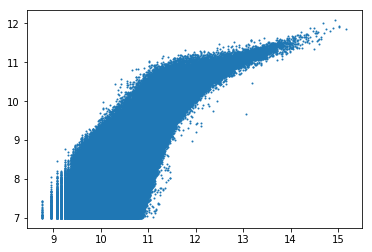

In [3]:
mhalo = galaxies[:,6]
mpeak = galaxies[:,10]
mstar = galaxies[:,7]

print(mhalo[:10])
print(mstar[:10])

plt.scatter(mhalo, mstar, s=1)

In [4]:
n_data_points = galaxies.shape[0]
subset_indices = np.random.choice(n_data_points, total_set_size, replace=False)
train_indices = subset_indices[:int(total_set_size*training_set_fraction)]
val_indices = subset_indices[int(total_set_size*training_set_fraction):
                                    int(total_set_size*(training_set_fraction+validation_set_fraction))]
test_indices = subset_indices[int(total_set_size*(training_set_fraction+validation_set_fraction)):]

mhalo_train = galaxies[train_indices, 6]
mhalo_val = galaxies[val_indices, 6]
mhalo_test = galaxies[test_indices, 6]

mstar_train = galaxies[train_indices, 7]
mstar_val = galaxies[val_indices, 7]
mstar_test = galaxies[test_indices, 7]

In [5]:
def InitialiseParticles(nParticles,xMin,xMax,nVariables,alpha,deltaT):
    
    r1 = np.random.uniform(size=(nParticles,nVariables))
    r2 = np.random.uniform(size=(nParticles,nVariables))
    
    positions = xMin + r1 * (xMax - xMin)
    velocities = alpha/deltaT * ((xMin - xMax)/2 + r2 * (xMax-xMin))
    
    return (positions, velocities)

In [6]:
def UpdateParticles(positions, velocities, particleBestPositions, 
                    swarmBestPosition, inertiaWeight, vMax, c1, c2, deltaT):
    
    nVariables = velocities.shape[1]
    
    q = np.random.uniform(size = (np.shape(positions)[0], 1))
    qMatrix = q
    r = np.random.uniform(size = (np.shape(positions)[0], 1))
    rMatrix = r
    for iVar in range(nVariables-1):
        qMatrix = np.concatenate((qMatrix, q), axis = 1)
        rMatrix = np.concatenate((rMatrix, r), axis = 1)
    
    particleBestDifference = particleBestPositions - positions
    swarmBestDifference = (positions - swarmBestPosition) * (-1)
    
    velocities = inertiaWeight*velocities + c1*qMatrix*particleBestDifference/deltaT + \
        c2*rMatrix*swarmBestDifference/deltaT
    
    # now limit velocities to vMax
    
    absVelocities = np.sqrt(np.sum(np.power(velocities, 2), axis=1))
    tooFastParticleIndeces = (absVelocities > vMax)
    
    notEmpty = np.any(tooFastParticleIndeces) # checks if at least one element is true
    
    if notEmpty:
        indices = np.argwhere(tooFastParticleIndeces)
        for index in indices:
            velocities[index,:] = velocities[index,:] * vMax / absVelocities[index]
            
    newPositions = positions + velocities * deltaT
    
    return (newPositions, velocities)

In [7]:
def EvaluateParticles(positions, inputDim, nLayers, neuronsPerLayer, outputDim, model, mode='train'):
    
    particleScores = np.zeros(positions.shape[0])
    
    for iParticle in range(positions.shape[0]):
        
        (weightList, biasList) = ExtractWeights(positions[iParticle,:], inputDim, nLayers, neuronsPerLayer, outputDim)
        model = SetModelWeights(weightList, biasList, model)
        particleScores[iParticle] = EvaluateNN(model, mode)
    
    return particleScores

In [8]:
def ExtractWeights(variables, inputDim, nLayers, neuronsPerLayer, outputDim):
    
    weightList = [] # will contain a list of all the weight matrices 
    biasList = []   # will contain a list of all the biases

    weightCounter = 0 # to help assign weights and biases to their correct matrix

    ### Extract weight matrices
    weightMatrix = np.zeros((inputDim, neuronsPerLayer)) 
    #print(weightMatrix.shape)
    for i in range(inputDim):  
        #print(i)
        weightMatrix[i,:] = variables[weightCounter:weightCounter+neuronsPerLayer]
        weightCounter += neuronsPerLayer
    #print(weightMatrix.shape)
    weightList.append(weightMatrix)


    for iLayer in range(nLayers):
        #print(iLayer)
        #print(positions.shape)
        weightMatrix = np.zeros((neuronsPerLayer, neuronsPerLayer))
        for iNeuron in range(neuronsPerLayer):

            #print(positions[iParticle, weightCounter:weightCounter+neuronsPerLayer])
            #print(weightCounter)
            weightMatrix[iNeuron,:] = variables[weightCounter:weightCounter+neuronsPerLayer]
            weightCounter += neuronsPerLayer

        weightList.append(weightMatrix)

    weightMatrix = np.zeros((neuronsPerLayer, outputDim))
    for i in range(neuronsPerLayer):  
        weightMatrix[i,:] = variables[weightCounter:weightCounter+outputDim]
        weightCounter += outputDim

    weightList.append(weightMatrix)

    ### Extract bias vectors
    for iLayer in range(nLayers+1):

        biasVector = variables[weightCounter:weightCounter+neuronsPerLayer]
        weightCounter += neuronsPerLayer

        biasList.append(biasVector)

    biasVector = np.zeros((1,outputDim))
    biasVector = variables[weightCounter:weightCounter+outputDim] # for the output layer
    biasList.append(biasVector)

    weightCounter += outputDim

    # print(weightCounter, variables.shape[0])  # a check if the number of variables is correct
    return (weightList, biasList)
        

In [9]:
### Create model, weights will be updated later on
def CreateNN(inputDim, nLayers, neuronsPerLayer, outputDim, actFun = 'relu'):
    model = Sequential()
    model.add(Dense(neuronsPerLayer, input_dim = inputDim, activation = actFun))
    
    for i in range(0, nLayers):
        model.add(Dense(neuronsPerLayer, activation = actFun))
        
    model.add(Dense(outputDim, activation = None))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    
    return model

In [10]:
def EvaluateNN(model, mode):
        
    if mode == 'train':
        score = model.evaluate(mhalo_train, mstar_train, verbose=0)
    elif mode == 'val':
        score = model.evaluate(mhalo_val, mstar_val, verbose=0)
    elif mode == 'test':
        score = model.evaluate(mhalo_val, mstar_val, verbose=0)
    else:
        print('incorrect evaluation mode provided (\'train\'/\'val\'/\'test\' required)')
    
    return score[1]

In [11]:
def SetModelWeights(weightList, biasList, model):
    
    for i in range(len(weightList)):
        model.layers[i].set_weights([weightList[i], biasList[i]])
        
    return model

In [12]:
def PredictFunc(weightList, biasList, model):
    
    for i in range(len(weightList)):
        model.layers[i].set_weights([weightList[i], biasList[i]])
        
    predictedY = model.predict(mhalo_test)

In [13]:
nIterations = 1000
nParticles = 40
inputDim = 1
nLayers = 5 # nLayers + 1 = nHiddenLayers
outputDim = 1
neuronsPerLayer = 8
activationFunction = 'tanh'
nVariables = inputDim * neuronsPerLayer + nLayers * neuronsPerLayer * neuronsPerLayer + \
    neuronsPerLayer * outputDim + (nLayers+1) * neuronsPerLayer + outputDim
xMin = -10
xMax = 10
alpha = 1
deltaT = 1
vMax = (xMax-xMin) / deltaT
c1 = 2
c2 = 2
inertiaWeightStart = 1.4
inertiaWeightMin = 0.3
explorationFraction = 0.8

inertiaWeightReduction = np.exp(np.log(inertiaWeightMin/inertiaWeightStart) / explorationFraction / nIterations)
inertiaWeight = inertiaWeightStart

validationScoreHistory = []
swarmBest = 1e20
swarmBestPosition = np.zeros(nVariables)
particleBest = 1e20 * np.ones(nParticles)
particleBestPositions = np.zeros((nParticles, nVariables))

model = CreateNN(inputDim, nLayers, neuronsPerLayer, outputDim, activationFunction)
(positions, velocities) = InitialiseParticles(nParticles, xMin,xMax,nVariables,alpha,deltaT)

for iteration in range(nIterations):
    if (int(iteration/10) == iteration/10):
        (weightList, biasList) = ExtractWeights(swarmBestPosition, inputDim, nLayers, neuronsPerLayer, outputDim)
        model = SetModelWeights(weightList, biasList, model)
        valScore = EvaluateNN(model, mode = 'val')
        validationScoreHistory.append(valScore)
        print('Iteration %d. Validation mse score of best weights: %.3f.' % (iteration, validationScoreHistory[-1]))
        
    funcValues = EvaluateParticles(positions, inputDim, nLayers, neuronsPerLayer, outputDim, model, mode='train')
    
    for iParticle in range(nParticles):
        
        isSwarmBest = (funcValues[iParticle] < swarmBest)
        #print(iParticle)
        #print(particleBest[iParticle])
        isParticleBest = (funcValues[iParticle] < particleBest[iParticle])
        
        if isSwarmBest:
            swarmBestPosition = positions[iParticle,:]
            particleBestPositions[iParticle,:] = positions[iParticle,:]
            swarmBest = funcValues[iParticle]
            particleBest[iParticle] = funcValues[iParticle]
            
            print('Iteration %d, new swarm best: %.3f!' % (iteration, swarmBest))
        elif isParticleBest:
            particleBestPositions[iParticle,:] = positions[iParticle,:]
            particleBest[iParticle] = funcValues[iParticle]
            
    (positions, velocities) = UpdateParticles(positions,velocities,
        particleBestPositions,swarmBestPosition,inertiaWeight,vMax,c1,c2,deltaT)
    
    isExploring = (inertiaWeight > inertiaWeightMin)
    if isExploring:
        inertiaWeight = inertiaWeight * inertiaWeightReduction
        isExploring = (inertiaWeight > inertiaWeightMin)
        if not(isExploring):
            print('SWITCH TO EPLOIT! Iteration %d/%d.' % (iteration, nIterations))

(bestWeightList, bestBiasList) = ExtractWeights(swarmBestPosition, inputDim, nLayers, neuronsPerLayer, outputDim)
        
print('Lowest mse error after %d iterations is %.6f,' % (nIterations,swarmBest))

Iteration 0. Validation mse score of best weights: 64.597.
Iteration 0, new swarm best: 38.808!
Iteration 0, new swarm best: 5.356!
Iteration 1, new swarm best: 0.905!
Iteration 3, new swarm best: 0.901!
Iteration 5, new swarm best: 0.882!
Iteration 5, new swarm best: 0.881!
Iteration 9, new swarm best: 0.859!
Iteration 9, new swarm best: 0.850!
Iteration 10. Validation mse score of best weights: 0.967.
Iteration 13, new swarm best: 0.848!
Iteration 16, new swarm best: 0.848!
Iteration 20. Validation mse score of best weights: 0.963.
Iteration 20, new swarm best: 0.838!
Iteration 30. Validation mse score of best weights: 0.954.
Iteration 33, new swarm best: 0.821!
Iteration 35, new swarm best: 0.821!
Iteration 40. Validation mse score of best weights: 0.928.
Iteration 41, new swarm best: 0.792!
Iteration 50. Validation mse score of best weights: 0.893.
Iteration 50, new swarm best: 0.788!
Iteration 50, new swarm best: 0.447!
Iteration 52, new swarm best: 0.402!
Iteration 60. Validation

Iteration 440, new swarm best: 0.278!
Iteration 440, new swarm best: 0.278!
Iteration 440, new swarm best: 0.278!
Iteration 440, new swarm best: 0.278!
Iteration 440, new swarm best: 0.278!
Iteration 441, new swarm best: 0.278!
Iteration 441, new swarm best: 0.278!
Iteration 441, new swarm best: 0.278!
Iteration 442, new swarm best: 0.278!
Iteration 442, new swarm best: 0.278!
Iteration 442, new swarm best: 0.278!
Iteration 442, new swarm best: 0.278!
Iteration 442, new swarm best: 0.278!
Iteration 442, new swarm best: 0.278!
Iteration 443, new swarm best: 0.278!
Iteration 443, new swarm best: 0.278!
Iteration 444, new swarm best: 0.278!
Iteration 444, new swarm best: 0.278!
Iteration 445, new swarm best: 0.278!
Iteration 445, new swarm best: 0.278!
Iteration 445, new swarm best: 0.278!
Iteration 446, new swarm best: 0.278!
Iteration 446, new swarm best: 0.278!
Iteration 446, new swarm best: 0.278!
Iteration 447, new swarm best: 0.278!
Iteration 447, new swarm best: 0.278!
Iteration 44

200/200 [==============================] - 0s 83us/step


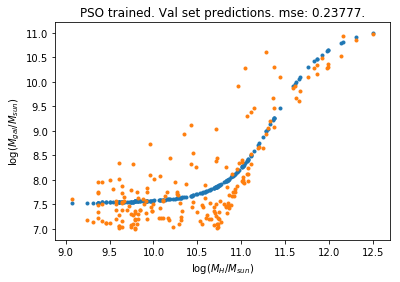

In [24]:
model = SetModelWeights(bestWeightList, bestBiasList, model)
error = model.evaluate(mhalo_val, mstar_val)
predictedY = model.predict(mhalo_val)
fig = plt.figure()
plt.scatter(mhalo_val, predictedY, marker='.')
plt.scatter(mhalo_val, mstar_val, marker='.')
plt.xlabel('log($M_H/M_{sun}$)')
plt.ylabel('log($M_{gal}/M_{sun}$)')
plt.title('PSO trained. Val set predictions. mse: %.5f.' % (error[1]))
fig.savefig('pso_mhalo_to_mgalaxy.png')

In [15]:
#print(bestWeightList)